In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
def get_recent_form(data, team, n_matches=5):
    team_data = data[(data['home_team'] == team) | (data['away_team'] == team)].tail(n_matches)
    wins = 0
    draws = 0
    losses = 0
    for _, row in team_data.iterrows():
        if row['result'] == 1 and row['home_team'] == team:
            wins += 1
        elif row['result'] == -1 and row['away_team'] == team:
            wins += 1
        elif row['result'] == 0:
            draws += 1
        else:
            losses += 1

    return wins / n_matches, draws / n_matches, losses / n_matches

In [4]:
data = pd.read_csv("../data/csv_datasets/epl/all_seasons.csv")

In [5]:
le_home = LabelEncoder()
le_away = LabelEncoder()

In [6]:
data['home_team'] = le_home.fit_transform(data['home_team'])
data.head()

,fixture_id,season,date,stadium,game_week,home_team,away_team,home_goals,away_goals,ht_home_goals,...,away_shots,away_fouls,away_corners,away_offsides,away_possession,away_yellow_cards,away_red_cards,away_goalkeeper_saves,away_attempted_passes,away_successful_passes
0,17696,2016,2016-08-13T11:30:00+00:00,KCOM Stadium,Regular Season - 1,12,Leicester,2,1,1,...,18,17,3,0,51,2,0,3,453,352
1,17691,2016,2016-08-13T14:00:00+00:00,Turf Moor,Regular Season - 1,5,Swansea,0,1,0,...,17,14,4,2,53,2,0,3,383,297
2,17692,2016,2016-08-13T14:00:00+00:00,Selhurst Park,Regular Season - 1,8,West Brom,0,1,0,...,13,15,6,2,38,2,0,4,245,143
3,17693,2016,2016-08-13T14:00:00+00:00,Goodison Park,Regular Season - 1,9,Tottenham,1,1,1,...,13,14,6,0,58,0,0,5,483,384
4,17694,2016,2016-08-13T14:00:00+00:00,Riverside,Regular Season - 1,18,Stoke City,1,1,1,...,12,14,6,2,55,5,0,1,420,330


In [7]:
data['away_team'] = le_away.fit_transform(data['away_team'])
data.head()

,fixture_id,season,date,stadium,game_week,home_team,away_team,home_goals,away_goals,ht_home_goals,...,away_shots,away_fouls,away_corners,away_offsides,away_possession,away_yellow_cards,away_red_cards,away_goalkeeper_saves,away_attempted_passes,away_successful_passes
0,17696,2016,2016-08-13T11:30:00+00:00,KCOM Stadium,Regular Season - 1,12,14,2,1,1,...,18,17,3,0,51,2,0,3,453,352
1,17691,2016,2016-08-13T14:00:00+00:00,Turf Moor,Regular Season - 1,5,26,0,1,0,...,17,14,4,2,53,2,0,3,383,297
2,17692,2016,2016-08-13T14:00:00+00:00,Selhurst Park,Regular Season - 1,8,29,0,1,0,...,13,15,6,2,38,2,0,4,245,143
3,17693,2016,2016-08-13T14:00:00+00:00,Goodison Park,Regular Season - 1,9,27,1,1,1,...,13,14,6,0,58,0,0,5,483,384
4,17694,2016,2016-08-13T14:00:00+00:00,Riverside,Regular Season - 1,18,24,1,1,1,...,12,14,6,2,55,5,0,1,420,330


In [8]:
data['game_week'] = data['game_week'].str.extract('(\d+)').astype(int)
data.head()

,fixture_id,season,date,stadium,game_week,home_team,away_team,home_goals,away_goals,ht_home_goals,...,away_shots,away_fouls,away_corners,away_offsides,away_possession,away_yellow_cards,away_red_cards,away_goalkeeper_saves,away_attempted_passes,away_successful_passes
0,17696,2016,2016-08-13T11:30:00+00:00,KCOM Stadium,1,12,14,2,1,1,...,18,17,3,0,51,2,0,3,453,352
1,17691,2016,2016-08-13T14:00:00+00:00,Turf Moor,1,5,26,0,1,0,...,17,14,4,2,53,2,0,3,383,297
2,17692,2016,2016-08-13T14:00:00+00:00,Selhurst Park,1,8,29,0,1,0,...,13,15,6,2,38,2,0,4,245,143
3,17693,2016,2016-08-13T14:00:00+00:00,Goodison Park,1,9,27,1,1,1,...,13,14,6,0,58,0,0,5,483,384
4,17694,2016,2016-08-13T14:00:00+00:00,Riverside,1,18,24,1,1,1,...,12,14,6,2,55,5,0,1,420,330


In [9]:
data['result'] = np.sign(data['home_goals'] - data['away_goals']).map({-1: 0, 0: 1, 1: 2})
data.head()

,fixture_id,season,date,stadium,game_week,home_team,away_team,home_goals,away_goals,ht_home_goals,...,away_fouls,away_corners,away_offsides,away_possession,away_yellow_cards,away_red_cards,away_goalkeeper_saves,away_attempted_passes,away_successful_passes,result
0,17696,2016,2016-08-13T11:30:00+00:00,KCOM Stadium,1,12,14,2,1,1,...,17,3,0,51,2,0,3,453,352,2
1,17691,2016,2016-08-13T14:00:00+00:00,Turf Moor,1,5,26,0,1,0,...,14,4,2,53,2,0,3,383,297,0
2,17692,2016,2016-08-13T14:00:00+00:00,Selhurst Park,1,8,29,0,1,0,...,15,6,2,38,2,0,4,245,143,0
3,17693,2016,2016-08-13T14:00:00+00:00,Goodison Park,1,9,27,1,1,1,...,14,6,0,58,0,0,5,483,384,1
4,17694,2016,2016-08-13T14:00:00+00:00,Riverside,1,18,24,1,1,1,...,14,6,2,55,5,0,1,420,330,1


In [10]:
scaling_factor = 2

data['home_recent_wins'] = data['home_team'].apply(lambda x: get_recent_form(data, x)[0]) * scaling_factor
data['home_recent_draws'] = data['home_team'].apply(lambda x: get_recent_form(data, x)[1]) * scaling_factor
data['home_recent_losses'] = data['home_team'].apply(lambda x: get_recent_form(data, x)[2]) * scaling_factor
data['away_recent_wins'] = data['away_team'].apply(lambda x: get_recent_form(data, x)[0]) * scaling_factor
data['away_recent_draws'] = data['away_team'].apply(lambda x: get_recent_form(data, x)[1]) * scaling_factor
data['away_recent_losses'] = data['away_team'].apply(lambda x: get_recent_form(data, x)[2]) * scaling_factor
data.head()

,fixture_id,season,date,stadium,game_week,home_team,away_team,home_goals,away_goals,ht_home_goals,...,away_goalkeeper_saves,away_attempted_passes,away_successful_passes,result,home_recent_wins,home_recent_draws,home_recent_losses,away_recent_wins,away_recent_draws,away_recent_losses
0,17696,2016,2016-08-13T11:30:00+00:00,KCOM Stadium,1,12,14,2,1,1,...,3,453,352,2,0.0,0.8,1.2,0.0,0.8,1.2
1,17691,2016,2016-08-13T14:00:00+00:00,Turf Moor,1,5,26,0,1,0,...,3,383,297,0,0.0,1.2,0.8,0.0,1.2,0.8
2,17692,2016,2016-08-13T14:00:00+00:00,Selhurst Park,1,8,29,0,1,0,...,4,245,143,0,0.4,0.4,1.2,0.4,0.8,0.8
3,17693,2016,2016-08-13T14:00:00+00:00,Goodison Park,1,9,27,1,1,1,...,5,483,384,1,0.0,0.4,1.6,0.0,0.0,2.0
4,17694,2016,2016-08-13T14:00:00+00:00,Riverside,1,18,24,1,1,1,...,1,420,330,1,0.4,0.4,1.2,0.4,0.8,0.8


In [11]:
features = [
    'game_week',
    'home_team',
    'away_team',
    'home_shots_on_target',
    'home_shots',
    'home_fouls',
    'home_corners',
    'home_offsides',
    'home_possession',
    'home_yellow_cards',
    'home_red_cards',
    'home_goalkeeper_saves',
    'home_attempted_passes',
    'home_successful_passes',
    'away_shots_on_target',
    'away_shots',
    'away_fouls',
    'away_corners',
    'away_offsides',
    'away_possession',
    'away_yellow_cards',
    'away_red_cards',
    'away_goalkeeper_saves',
    'away_attempted_passes',
    'away_successful_passes',
    'home_recent_wins',
    'home_recent_draws',
    'home_recent_losses',
    'away_recent_wins',
    'away_recent_draws',
    'away_recent_losses'
]

ml_features = data[features]

ml_features

,game_week,home_team,away_team,home_shots_on_target,home_shots,home_fouls,home_corners,home_offsides,home_possession,home_yellow_cards,...,away_red_cards,away_goalkeeper_saves,away_attempted_passes,away_successful_passes,home_recent_wins,home_recent_draws,home_recent_losses,away_recent_wins,away_recent_draws,away_recent_losses
0,1,12,14,5,14,8,5,1,49,2,...,0,3,453,352,0.0,0.8,1.2,0.0,0.8,1.2
1,1,5,26,3,10,10,7,3,47,3,...,0,3,383,297,0.0,1.2,0.8,0.0,1.2,0.8
2,1,8,29,4,14,12,3,0,62,2,...,0,4,245,143,0.4,0.4,1.2,0.4,0.8,0.8
3,1,9,27,6,12,10,5,5,42,0,...,0,5,483,384,0.0,0.4,1.6,0.0,0.0,2.0
4,1,18,24,2,12,18,9,1,45,3,...,0,1,420,330,0.4,0.4,1.2,0.4,0.8,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2540,27,19,31,8,19,11,10,0,42,1,...,0,6,425,345,0.0,0.8,1.2,0.0,0.4,1.6
2541,7,23,3,1,7,14,3,1,66,1,...,0,0,289,186,0.0,0.8,1.2,0.4,0.4,1.2
2542,8,4,8,5,11,13,1,2,57,1,...,0,4,430,345,0.0,0.4,1.6,0.4,0.4,1.2
2543,28,21,19,3,5,17,3,1,38,5,...,0,2,449,358,0.8,0.4,0.8,0.0,0.8,1.2


In [12]:
ml_target = data['result']

ml_target

0       2
1       0
2       0
3       1
4       1
       ..
2540    2
2541    0
2542    2
2543    0
2544    2
Name: result, Length: 2545, dtype: int64

In [13]:
ml_features_train, ml_features_test, ml_target_train, ml_target_test = train_test_split(ml_features, ml_target, test_size=0.2, random_state=42)

xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(ml_features_train, ml_target_train, eval_metric='mlogloss')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [14]:
model_test = xgb.predict(ml_features_test)

In [15]:
cv_scores = cross_val_score(xgb, ml_features, ml_target, cv=5)

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.4f}")

Cross-validation scores: [0.7956778  0.78192534 0.7740668  0.76031434 0.74656189]
Mean cross-validation score: 0.7717


In [16]:
accuracy = accuracy_score(ml_target_test, model_test)
precision = precision_score(ml_target_test, model_test, average='weighted')
recall = recall_score(ml_target_test, model_test, average='weighted')
f1 = f1_score(ml_target_test, model_test, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1 * 100:.2f}%")

Accuracy: 77.41%
Precision: 76.18%
Recall: 77.41%
F1-score: 76.57%


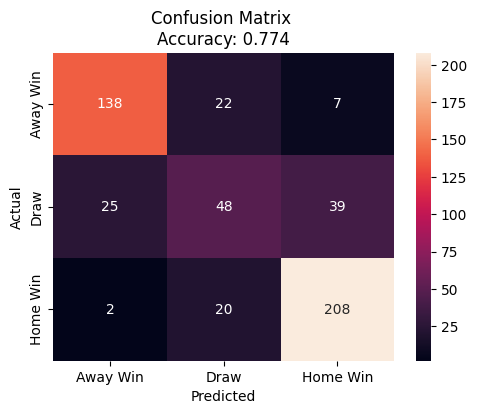

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ml_target_test, model_test)
cm_df = pd.DataFrame(cm, index=['Away Win', 'Draw', 'Home Win'], columns=['Away Win', 'Draw', 'Home Win'])
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix \nAccuracy: {0:.3f}'.format(accuracy_score(ml_target_test, model_test)))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [18]:
def predict_outcome(home_team, away_team):
    home_recent_wins, home_recent_draws, home_recent_losses = get_recent_form(data, le_home.transform([home_team])[0])
    away_recent_wins, away_recent_draws, away_recent_losses = get_recent_form(data, le_away.transform([away_team])[0])
    
    input_data = np.array([
        [1, le_home.transform([home_team])[0], le_away.transform([away_team])[0]] + [0] * 22 +
        [home_recent_wins * scaling_factor, home_recent_draws * scaling_factor, home_recent_losses * scaling_factor,
        away_recent_wins * scaling_factor, away_recent_draws * scaling_factor, away_recent_losses * scaling_factor]
    ])
    prediction = xgb.predict(input_data)[0]
    probabilities = xgb.predict_proba(input_data)[0]
    return prediction, probabilities

In [19]:
fixtures = [
    ['Arsenal', 'Southampton'],
    ['Fulham', 'Leeds'],
    ['Manchester United', 'Chelsea'],
    ['Crystal Palace', 'Everton'],
    ['Liverpool', 'Nottingham Forest'],
    ['Brentford', 'Aston Villa'],
    ['Leicester', 'Wolves'],
    ['Brighton', 'Manchester City'],
    ['Newcastle', 'Tottenham'],
    ['Bournemouth', 'West Ham'],
    ]

for fixture in fixtures:
    home_team = fixture[0]
    away_team = fixture[1]
    prediction, probabilities = predict_outcome(home_team, away_team)

    print(f"{home_team} (Home) Win - {probabilities[2] * 100:.2f}%")
    print(f"{away_team} (Away) Win - {probabilities[0] * 100:.2f}%")
    print(f"Draw - {probabilities[1] * 100:.2f}%\n")

Arsenal (Home) Win - 21.60%
Southampton (Away) Win - 77.15%
Draw - 1.26%

Fulham (Home) Win - 37.79%
Leeds (Away) Win - 60.98%
Draw - 1.23%

Manchester United (Home) Win - 23.03%
Chelsea (Away) Win - 74.26%
Draw - 2.71%

Crystal Palace (Home) Win - 27.20%
Everton (Away) Win - 69.11%
Draw - 3.69%

Liverpool (Home) Win - 19.71%
Nottingham Forest (Away) Win - 78.07%
Draw - 2.21%

Brentford (Home) Win - 32.00%
Aston Villa (Away) Win - 64.35%
Draw - 3.65%

Leicester (Home) Win - 28.99%
Wolves (Away) Win - 69.14%
Draw - 1.87%

Brighton (Home) Win - 48.86%
Manchester City (Away) Win - 49.93%
Draw - 1.21%

Newcastle (Home) Win - 11.62%
Tottenham (Away) Win - 86.03%
Draw - 2.34%

Bournemouth (Home) Win - 27.26%
West Ham (Away) Win - 71.88%
Draw - 0.86%



: 